In [ ]:
!pip install sentinelhub rasterio tqdm

In [ ]:
#@title 2.0 – SH setup, extractor & preprocessor
#@markdown This cell:
#@markdown - Configures Sentinel Hub auth and Drive output
#@markdown - Defines the extractor for Sentinel-2 indices (NDVI, NDMI, etc.)
#@markdown - Defines the preprocessor to build patch sequences
#@markdown - Runs extraction + preprocessing for the Wadi test area

import os
import shutil
import math
import numpy as np
import rasterio
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, MimeType, BBox, CRS
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import re
import gc

# 1. AUTHENTICATION
config = SHConfig()
config.instance_id       = "60de79ca-16a7-4afd-bcbd-0261bf0156fa"
config.sh_client_id      = "c24dd5e9-a6b8-4691-8b89-1a8cfc1738b2"
config.sh_client_secret  = "0JgkgIrX376h8UuCsWxophG8dYeRpggG"

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Create Output Folder
DRIVE_FOLDER = "/content/drive/MyDrive/Dune_Backup_Data"
os.makedirs(DRIVE_FOLDER, exist_ok=True)

# Install Dependencies
try:
    import sentinelhub
except ImportError:
    !pip install sentinelhub rasterio tqdm

# PART 2: EXTRACTOR ENGINE
def get_time_intervals(start, end, interval):
    intervals = []
    current = datetime.strptime(start, "%Y-%m-%d")
    end_dt = datetime.strptime(end, "%Y-%m-%d")
    while current < end_dt:
        next_time = current + relativedelta(months=1)
        intervals.append((current.strftime("%Y-%m-%d"), min(next_time, end_dt).strftime("%Y-%m-%d")))
        current = next_time
    return intervals

def make_size(bbox_obj, resolution):
    hight = ((bbox_obj.max_y - bbox_obj.min_y) * 111320 ) / resolution
    width = ((bbox_obj.max_x - bbox_obj.min_x) * 111320 * math.cos(math.radians((bbox_obj.max_y + bbox_obj.min_y)/2))) / resolution
    return (int(width), int(hight))

def run_extraction(name, coords, start_date, end_date):
    print(f"\n🌍 STARTING EXTRACTION FOR: {name}")

    # Fresh Start
    if os.path.exists("formatted_data"): shutil.rmtree("formatted_data")
    os.makedirs("formatted_data", exist_ok=True)

    # Use SentinelHub CRS object here (Correct)
    bbox_obj = BBox(coords, crs=CRS.WGS84)
    time_intervals = get_time_intervals(start_date, end_date, '1M')

    evalscript = """
    //VERSION=3
    function setup() {
      return {
        input: ["B02", "B04", "B08", "B11"],
        output: { bands: 4, sampleType: "FLOAT32" }
      };
    }
    function evaluatePixel(sample) {
      return [sample.B02, sample.B04, sample.B08, sample.B11];
    }
    """

    pbar = tqdm(time_intervals, desc="Downloading")
    for t_start, t_end in pbar:
        timewindow = f"{t_start}_{t_end}"
        request = SentinelHubRequest(
            evalscript=evalscript,
            input_data=[SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(t_start, t_end),
                mosaicking_order='leastCC',
                other_args={"maxCloudCoverage": 30}
            )],
            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
            bbox=bbox_obj,
            size=make_size(bbox_obj, 10),
            config=config
        )

        data = request.get_data()
        if not data:
            continue

        indices_dir = os.path.join("formatted_data", timewindow, "indices")
        os.makedirs(indices_dir, exist_ok=True)
        img = data[0]

        blue, red, nir, swir = img[:,:,0], img[:,:,1], img[:,:,2], img[:,:,3]

        h, w = blue.shape
        tfm = rasterio.transform.from_bounds(*bbox_obj, w, h)

        prof = {'driver': 'GTiff', 'height': h, 'width': w, 'count': 1, 'dtype': 'float32', 'crs': 'EPSG:4326', 'transform': tfm}

        def save_safe(arr, n):
            clean_arr = np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=-1.0)
            with rasterio.open(os.path.join(indices_dir, n), 'w', **prof) as d:
                d.write(clean_arr.astype('float32'), 1)

        # CALC INDICES
        save_safe((nir - red) / (nir + red + 1e-6), "NDVI.tiff")
        save_safe((nir - swir) / (nir + swir + 1e-6), "NDMI.tiff")
        save_safe(((swir+red)-(nir+blue))/((swir+red)+(nir+blue)+1e-6), "BSI.tiff")
        save_safe(((nir-red)*1.5)/(nir+red+0.5+1e-6), "SAVI.tiff")
        save_safe(2.5*((nir-red)/(nir+(6*red)-(7.5*blue)+1+1e-6)), "EVI.tiff")


# PART 3: PREPROCESSOR
def run_preprocessing(location_name):
    print(f"\n⚙️ PROCESSING: {location_name}")
    DATA_DIR = "formatted_data"
    PATCH_SIZE = 128
    SEQ_LEN = 4
    INDICES = ["NDVI", "NDMI", "BSI", "SAVI", "EVI"]

    def natural_sort_key(s):
        return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

    def load_stack(path):
        stack = []
        for idx in INDICES:
            with rasterio.open(os.path.join(path, "indices", f"{idx}.tiff")) as src:
                arr = src.read(1).astype(np.float32)
                arr = np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=-1.0)
                if idx == "EVI": arr /= 1.5
                elif idx == "BSI": arr /= 3.0
                stack.append(arr)
        return np.stack(stack, axis=-1)

    def get_patches(img):
        H, W, C = img.shape
        p = []
        for y in range(0, H, PATCH_SIZE):
            for x in range(0, W, PATCH_SIZE):
                if y+PATCH_SIZE <= H and x+PATCH_SIZE <= W:
                    p.append(img[y:y+PATCH_SIZE, x:x+PATCH_SIZE])
        return p

    time_folders = sorted([f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))], key=natural_sort_key)
    if not time_folders: return

    temp = load_stack(os.path.join(DATA_DIR, time_folders[0]))
    patches_per_step = len(get_patches(temp))
    total_seq = (len(time_folders) - SEQ_LEN) * patches_per_step
    print(f"   -> Samples to generate: {total_seq}")

    X_name = f"X_{location_name}.npy"
    Y_name = f"Y_{location_name}.npy"

    X = np.memmap(X_name, dtype='float32', mode='w+', shape=(total_seq, SEQ_LEN, PATCH_SIZE, PATCH_SIZE, 5))
    Y = np.memmap(Y_name, dtype='float32', mode='w+', shape=(total_seq, PATCH_SIZE, PATCH_SIZE, 5))

    buffer = [load_stack(os.path.join(DATA_DIR, time_folders[t])) for t in range(SEQ_LEN)]
    write_idx = 0

    for t in tqdm(range(SEQ_LEN, len(time_folders)), desc="Preprocessing"):
        target = load_stack(os.path.join(DATA_DIR, time_folders[t]))
        t_patches = get_patches(target)
        b_patches = [get_patches(b) for b in buffer]

        for p in range(patches_per_step):
            seq = np.array([b_patches[i][p] for i in range(SEQ_LEN)])
            X[write_idx] = seq
            Y[write_idx] = t_patches[p]
            write_idx += 1

        del buffer[0]
        buffer.append(target)
        gc.collect()

    X.flush()
    Y.flush()

    print(f"🚀 SAVING TO DRIVE...")
    shutil.move(X_name, os.path.join(DRIVE_FOLDER, X_name))
    shutil.move(Y_name, os.path.join(DRIVE_FOLDER, Y_name))
    print("✅ Done.")

# PART 4: EXECUTE

# 1. WADI AD-DAWASIR (Only run this one for now to verify)
run_extraction("Wadi", [44.75, 20.45, 44.95, 20.65], "2017-01-01", "2025-11-30")
run_preprocessing("wadi")


ModuleNotFoundError: No module named 'sentinelhub'

In [ ]:
#@title 3.0 – Chunk and upload big Wadi dataset to Drive
#@markdown This cell:
#@markdown - Attaches to the full Wadi dataset stored as memmap files
#@markdown - Splits X and Y into manageable chunks to avoid Colab crashes
#@markdown - Saves each chunk directly into your Google Drive folder

import numpy as np
import os
import gc

# 1. SETUP DIMENSIONS (From your logs)
total_seq = 28016
SEQ_LEN = 4
PATCH_SIZE = 128
CHANNELS = 5

DRIVE_FOLDER = "/content/drive/MyDrive/Dune_Backup_Data"
os.makedirs(DRIVE_FOLDER, exist_ok=True)

print(f"📦 FOUND 2TB DRIVE! Preparing to upload full dataset ({total_seq} samples)...")

# 2. CONNECT TO THE BIG FILE (Read-Only to save RAM)
# We map the file on disk so we don't load 40GB into RAM
X_big = np.memmap('X_wadi.npy', dtype='float32', mode='r', shape=(total_seq, SEQ_LEN, PATCH_SIZE, PATCH_SIZE, CHANNELS))
Y_big = np.memmap('Y_wadi.npy', dtype='float32', mode='r', shape=(total_seq, PATCH_SIZE, PATCH_SIZE, CHANNELS))

# 3. SPLIT INTO 4 CHUNKS
# 28,000 / 4 = 7,000 samples per chunk (~8.5 GB each)
# This is small enough to upload without crashing Colab.
CHUNK_SIZE = 7004
num_chunks = int(np.ceil(total_seq / CHUNK_SIZE))

print(f"🔪 Splitting data into {num_chunks} chunks to bypass Colab limits...")

for i in range(num_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, total_seq)

    print(f"\n🚀 Processing Chunk {i+1}/{num_chunks} (Samples {start} to {end})...")

    # Create filenames
    x_name = f"X_wadi_part{i+1}.npy"
    y_name = f"Y_wadi_part{i+1}.npy"
    x_path = os.path.join(DRIVE_FOLDER, x_name)
    y_path = os.path.join(DRIVE_FOLDER, y_name)

    # Save directly to Drive
    # We convert to a regular array just for the slice to ensure clean saving
    np.save(x_path, np.array(X_big[start:end]))
    print(f"   ✅ Saved {x_name}")

    np.save(y_path, np.array(Y_big[start:end]))
    print(f"   ✅ Saved {y_name}")

    # Force memory cleanup
    gc.collect()

print("\n🎉 MISSION ACCOMPLISHED.")
print("All 9 years of data are safely in your Drive.")


📦 FOUND 2TB DRIVE! Preparing to upload full dataset (28016 samples)...
🔪 Splitting data into 4 chunks to bypass Colab limits...

🚀 Processing Chunk 1/4 (Samples 0 to 7004)...
   ✅ Saved X_wadi_part1.npy
   ✅ Saved Y_wadi_part1.npy

🚀 Processing Chunk 2/4 (Samples 7004 to 14008)...


OSError: 2295070720 requested and 2246833120 written

In [ ]:
#@title 3.1 – Fix and re-upload corrupted chunks
#@markdown This cell:
#@markdown - Deletes possibly corrupted chunk files (parts 2–4) from Drive
#@markdown - Re-attaches to the original big `X_wadi.npy` / `Y_wadi.npy` memmaps
#@markdown - Regenerates chunks 2–4 and uploads fresh, clean copies

import numpy as np
import os
import gc

# 1. SETUP
total_seq = 28016
SEQ_LEN = 4
PATCH_SIZE = 128
CHANNELS = 5
DRIVE_FOLDER = "/content/drive/MyDrive/Dune_Backup_Data"

print("🔥 FIXING CORRUPTED CHUNKS...")

# 2. DELETE BROKEN FILES (Part 2, 3, 4)
# We trust Part 1, but Part 2 was likely cut short by the disk crash.
for i in range(2, 5): # Chunks 2, 3, 4
    x_bad = os.path.join(DRIVE_FOLDER, f"X_wadi_part{i}.npy")
    y_bad = os.path.join(DRIVE_FOLDER, f"Y_wadi_part{i}.npy")

    if os.path.exists(x_bad):
        os.remove(x_bad)
        print(f"   🗑️ Deleted potentially corrupt {x_bad}")
    if os.path.exists(y_bad):
        os.remove(y_bad)
        print(f"   🗑️ Deleted potentially corrupt {y_bad}")

# 3. CONNECT TO SOURCE (Read-Only)
try:
    X_big = np.memmap('X_wadi.npy', dtype='float32', mode='r', shape=(total_seq, SEQ_LEN, PATCH_SIZE, PATCH_SIZE, CHANNELS))
    Y_big = np.memmap('Y_wadi.npy', dtype='float32', mode='r', shape=(total_seq, PATCH_SIZE, PATCH_SIZE, CHANNELS))
    print("✅ Source Data is Ready.")
except FileNotFoundError:
    print("❌ CRITICAL: Source file missing on Colab disk.")
    raise

# 4. UPLOAD FRESH CHUNKS (2, 3, 4)
CHUNK_SIZE = 7004
num_chunks = int(np.ceil(total_seq / CHUNK_SIZE))

# Start loop at 1 (which is Chunk 2)
for i in range(1, num_chunks):
    start = i * CHUNK_SIZE
    end = min((i + 1) * CHUNK_SIZE, total_seq)

    print(f"\n🚀 Re-Uploading Chunk {i+1}/{num_chunks} (Samples {start} to {end})...")

    x_name = f"X_wadi_part{i+1}.npy"
    y_name = f"Y_wadi_part{i+1}.npy"
    x_path = os.path.join(DRIVE_FOLDER, x_name)
    y_path = os.path.join(DRIVE_FOLDER, y_name)

    # Save Fresh
    np.save(x_path, np.array(X_big[start:end]))
    print(f"   ✅ Saved {x_name}")

    np.save(y_path, np.array(Y_big[start:end]))
    print(f"   ✅ Saved {y_name}")

    gc.collect()

print("\n🎉 ALL PARTS FIXED AND SAVED!")


🔥 FIXING CORRUPTED CHUNKS...
   🗑️ Deleted potentially corrupt /content/drive/MyDrive/Dune_Backup_Data/X_wadi_part2.npy
✅ Source Data is Ready.

🚀 Re-Uploading Chunk 2/4 (Samples 7004 to 14008)...
   ✅ Saved X_wadi_part2.npy
   ✅ Saved Y_wadi_part2.npy

🚀 Re-Uploading Chunk 3/4 (Samples 14008 to 21012)...
   ✅ Saved X_wadi_part3.npy
   ✅ Saved Y_wadi_part3.npy

🚀 Re-Uploading Chunk 4/4 (Samples 21012 to 28016)...
   ✅ Saved X_wadi_part4.npy
   ✅ Saved Y_wadi_part4.npy

🎉 ALL PARTS FIXED AND SAVED!


In [ ]:
#@title 4.0 – Low-RAM ConvLSTM training (streaming from Drive)
#@markdown This cell trains the Dune Reclaimer ConvLSTM model using a streaming generator.
#@markdown It keeps data on Drive and loads only small batches into memory, maintaining very low RAM usage (< 1GB).
#@markdown Strategy:
#@markdown - Stream chunks directly from Drive
#@markdown - Avoid loading full dataset into RAM
#@markdown - Use ConvLSTM with early stopping and checkpointing
#@markdown - Save the trained model and show a sample prediction

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import gc

# 1. SETUP
print("INITIALIZING LOW-RAM PIPELINE...")
from google.colab import drive
drive.mount('/content/drive')

DRIVE_FOLDER = "/content/drive/MyDrive/Dune_Backup_Data"
MODEL_SAVE_PATH = os.path.join(DRIVE_FOLDER, "dune_model_final.keras")

# 2. THE SMART GENERATOR saves RAM
class DuneGenerator(tf.keras.utils.Sequence):
    def __init__(self, drive_folder, batch_size=16, subset='train', val_split=0.2):
        self.batch_size = batch_size
        self.X_maps = []
        self.Y_maps = []
        self.global_indices = []

        print(f"Mapping files for {subset}...")
        total_samples = 0

        for i in range(1, 5):
            x_path = os.path.join(drive_folder, f"X_wadi_part{i}.npy")
            y_path = os.path.join(drive_folder, f"Y_wadi_part{i}.npy")

            if os.path.exists(x_path):
                x_ref = np.load(x_path, mmap_mode='r')
                y_ref = np.load(y_path, mmap_mode='r')

                count = len(x_ref)
                self.X_maps.append(x_ref)
                self.Y_maps.append(y_ref)

                for local_i in range(count):
                    self.global_indices.append((len(self.X_maps)-1, local_i))

                total_samples += count
                print(f"   Mapped Part {i} ({count} samples)")

        split_idx = int(len(self.global_indices) * (1 - val_split))
        if subset == 'train':
            self.indices = self.global_indices[:split_idx]
        else:
            self.indices = self.global_indices[split_idx:]

        print(f"Generator ready for {subset}: {len(self.indices)} samples")

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]

        X_batch = []
        Y_batch = []

        for part_id, local_id in batch_indices:
            X_batch.append(self.X_maps[part_id][local_id])
            Y_batch.append(self.Y_maps[part_id][local_id])

        return np.array(X_batch), np.array(Y_batch)

# 3. INITIALIZE GENERATORS
try:
    train_gen = DuneGenerator(DRIVE_FOLDER, batch_size=16, subset='train')
    val_gen   = DuneGenerator(DRIVE_FOLDER, batch_size=16, subset='val')
except Exception as e:
    print(f"Error initializing data: {e}")
    raise

# 4. DEFINE MODEL (ConvLSTM)
def build_model(input_shape):
    inp = layers.Input(shape=input_shape)

    x = layers.ConvLSTM2D(filters=32, kernel_size=(3,3), padding='same', return_sequences=True, activation='tanh')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', return_sequences=False, activation='tanh')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)

    out = layers.Conv2D(filters=5, kernel_size=(1,1), activation='linear', padding='same')(x)

    return models.Model(inp, out)

model = build_model((4, 128, 128, 5))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# 5. TRAIN
print("STARTING STREAMING TRAINING...")
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

print(f"MODEL SAVED: {MODEL_SAVE_PATH}")

# 6. TEST VISUALIZATION
print("Generating Test Plot...")
x_test, y_test = val_gen[0]
idx = 0

prediction = model.predict(x_test[idx:idx+1])

plt.figure(figsize=(10, 4))
plt.subplot(1,3,1); plt.title("Input (Last Step)"); plt.imshow(x_test[idx, -1, :, :, 0], cmap='RdYlGn')
plt.subplot(1,3,2); plt.title("Prediction (NDVI)"); plt.imshow(prediction[0, :, :, 0], cmap='RdYlGn')


🚀 INITIALIZING LOW-RAM PIPELINE...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Mapping files for train...
   -> Mapped Part 1 (7004 samples)
   -> Mapped Part 2 (7004 samples)
   -> Mapped Part 3 (7004 samples)
   -> Mapped Part 4 (7004 samples)
✅ Generator ready for train: 22412 samples
📦 Mapping files for val...
   -> Mapped Part 1 (7004 samples)
   -> Mapped Part 2 (7004 samples)
   -> Mapped Part 3 (7004 samples)
   -> Mapped Part 4 (7004 samples)
✅ Generator ready for val: 5604 samples


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 128, 128, 5) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 4, 128, 128,    │        42,752 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 128, 128,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 128, 128, 64)   │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 5)    │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,133 (1.22 MB)

 Trainable params: 319,941 (1.22 MB)

 Non-trainable params: 192 (768.00 B)


🔥 STARTING STREAMING TRAINING...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 1103s 774ms/step - loss: 12.9542 - mae: 0.0357 - val_loss: 102.3353 - val_mae: 0.0136
Epoch 2/15
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 873s 623ms/step - loss: 17.1559 - mae: 0.0139 - val_loss: 102.3353 - val_mae: 0.0139
Epoch 3/15
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 873s 623ms/step - loss: 2.3503 - mae: 0.0135 - val_loss: 102.3365 - val_mae: 0.0318
Epoch 4/15
 715/1400 ━━━━━━━━━━━━━━━━━━━━ 6:39 583ms/step - loss: 16.3205 - mae: 0.0132

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from google.colab import drive

# 1. MOUNT DRIVE
drive.mount('/content/drive')
DRIVE_FOLDER = "/content/drive/MyDrive/Dune_Backup_Data"
MODEL_PATH = os.path.join(DRIVE_FOLDER, "dune_model_final_manual_save.keras")

# 2. LOAD MODEL AND DATA
# We are using the PART 4 data (the most recent, 2023-2025) for testing.
x_path = os.path.join(DRIVE_FOLDER, "X_wadi_part4.npy")
y_path = os.path.join(DRIVE_FOLDER, "Y_wadi_part4.npy")

# CRITICAL: Define the global variables X_test, Y_test, and model
try:
    # Load data in read-only memory map mode to save RAM
    X_test = np.load(x_path, mmap_mode='r')
    Y_test = np.load(y_path, mmap_mode='r')
    print(f"✅ Data Loaded (X_test, Y_test) with {len(X_test)} samples.")

    # Load the trained Keras model
    global model
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Model Loaded Successfully.")

except Exception as e:
    print(f"❌ CRITICAL ERROR: Could not load data or model. Check file paths. Error: {e}")

Mounted at /content/drive
✅ Data Loaded (X_test, Y_test) with 7004 samples.
✅ Model Loaded Successfully.


📊 Generating Distribution Plots for 200 samples...


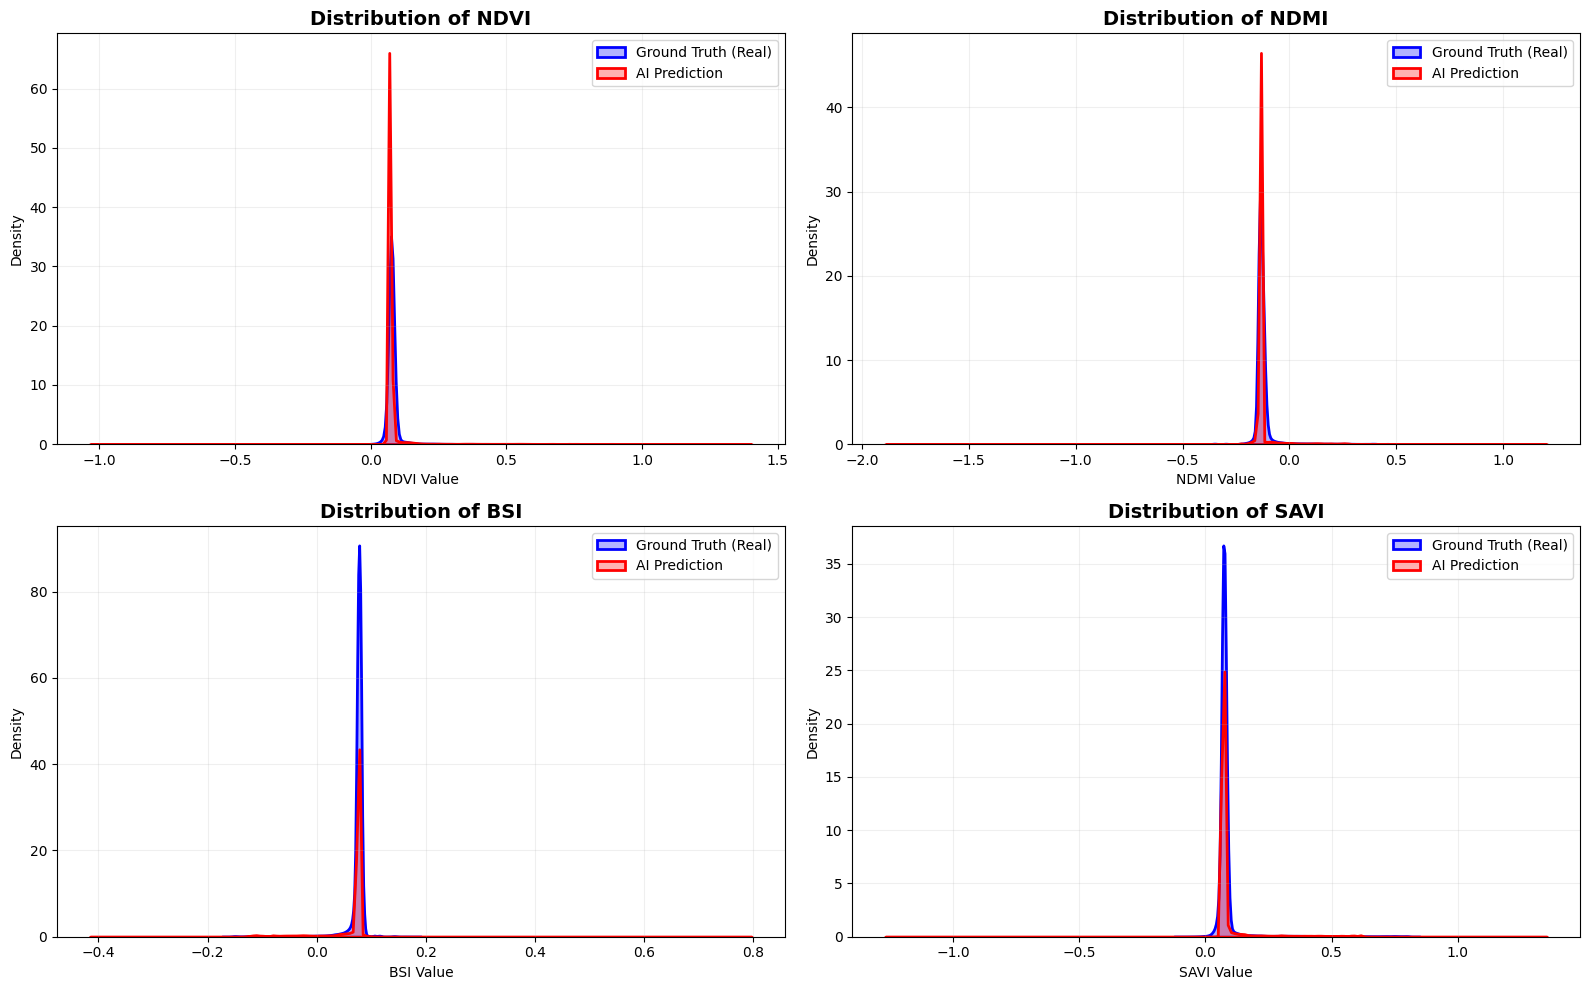

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
SAMPLES_TO_ANALYZE = 200  # Higher number = smoother curves (but takes more RAM)
INDICES_NAMES = ["NDVI", "NDMI", "BSI", "SAVI", "EVI"]

print(f"📊 Generating Distribution Plots for {SAMPLES_TO_ANALYZE} samples...")

# 1. GET DATA
# We take a random batch of test data to analyze
indices = np.random.choice(len(X_test), SAMPLES_TO_ANALYZE, replace=False)
x_batch = X_test[indices]
y_true_batch = Y_test[indices]

# 2. RUN PREDICTION
y_pred_batch = model.predict(x_batch, verbose=0)

# 3. SETUP PLOT
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# We will plot the first 4 indices (NDVI, NDMI, BSI, SAVI)
plot_indices = [0, 1, 2, 3] # Indices of channels to plot

for i, ax in zip(plot_indices, axes):
    channel_name = INDICES_NAMES[i]

    # Flatten data to 1D arrays (ignoring 0/masked values if necessary, but here we keep all)
    # We select the specific channel 'i' from the (Batch, 128, 128, 5) arrays
    true_vals = y_true_batch[:, :, :, i].flatten()
    pred_vals = y_pred_batch[:, :, :, i].flatten()

    # Optional: Filter out extreme outliers or padding (0s) if they skew the graph
    # true_vals = true_vals[true_vals != 0]
    # pred_vals = pred_vals[pred_vals != 0]

    # PLOT USING SEABORN (This creates the smooth 'shaded' look)
    sns.kdeplot(true_vals, fill=True, color="blue", label="Ground Truth (Real)", ax=ax, alpha=0.3, linewidth=2)
    sns.kdeplot(pred_vals, fill=True, color="red", label="AI Prediction", ax=ax, alpha=0.3, linewidth=2)

    # Styling to match your reference image
    ax.set_title(f"Distribution of {channel_name}", fontsize=14, fontweight='bold')
    ax.set_xlabel(f"{channel_name} Value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

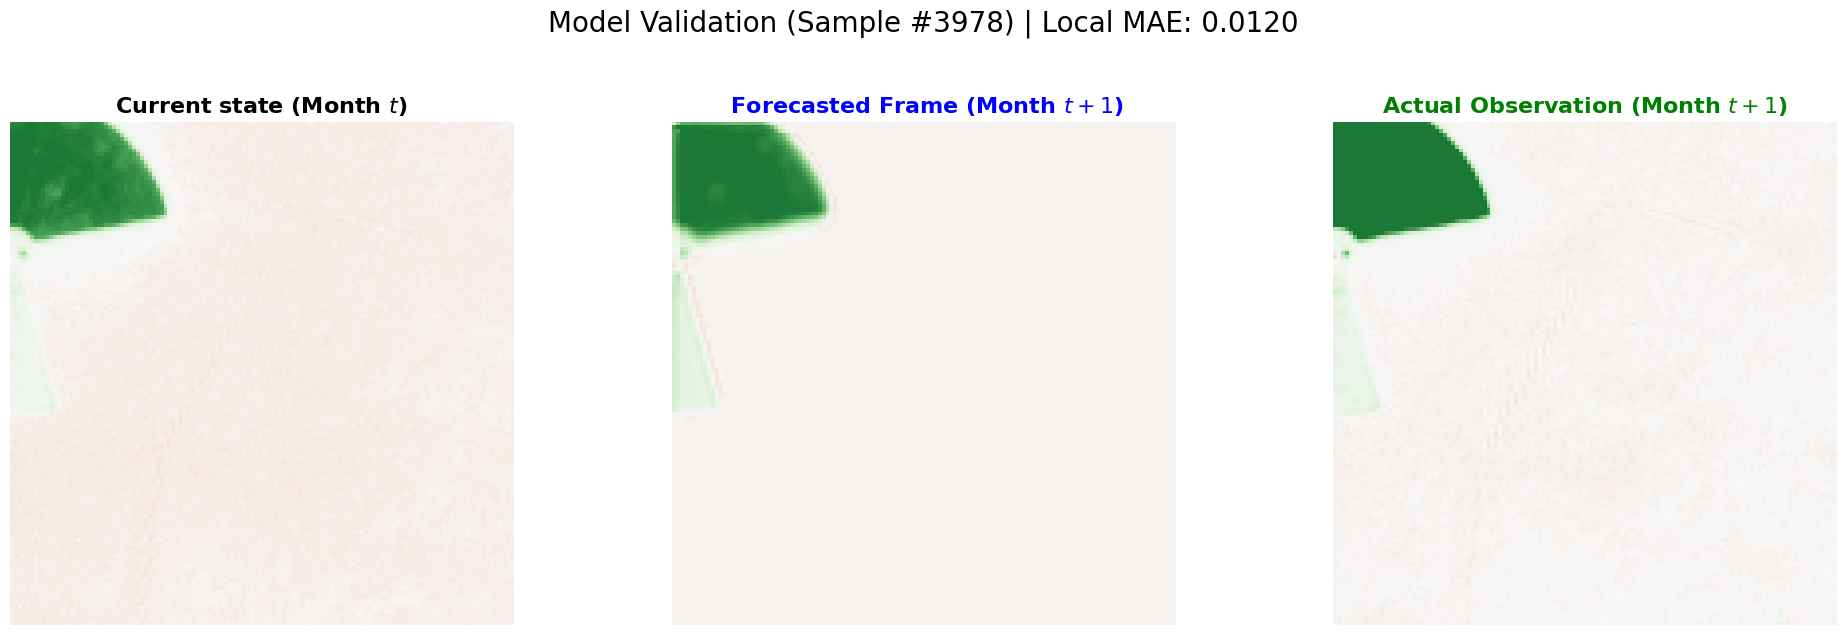

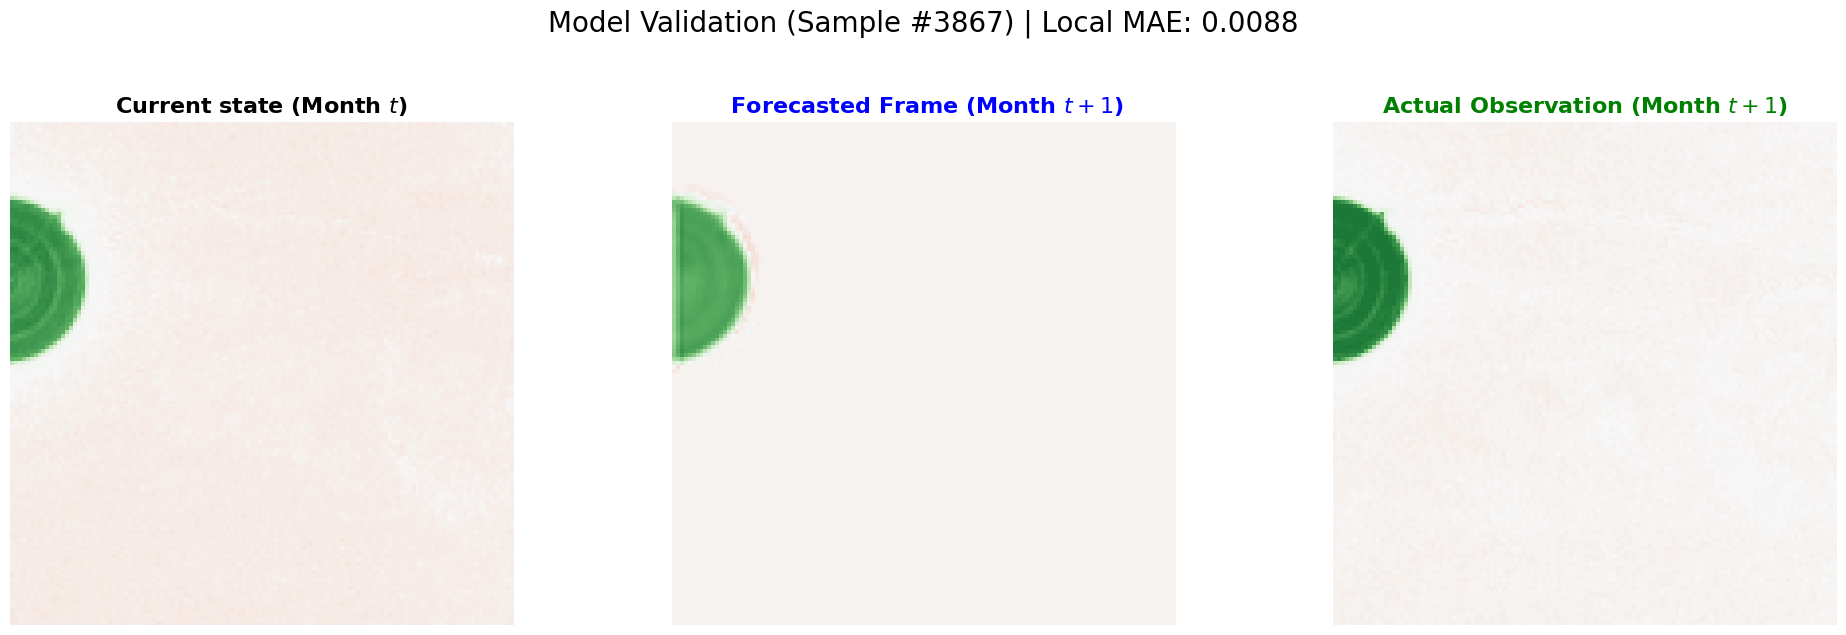

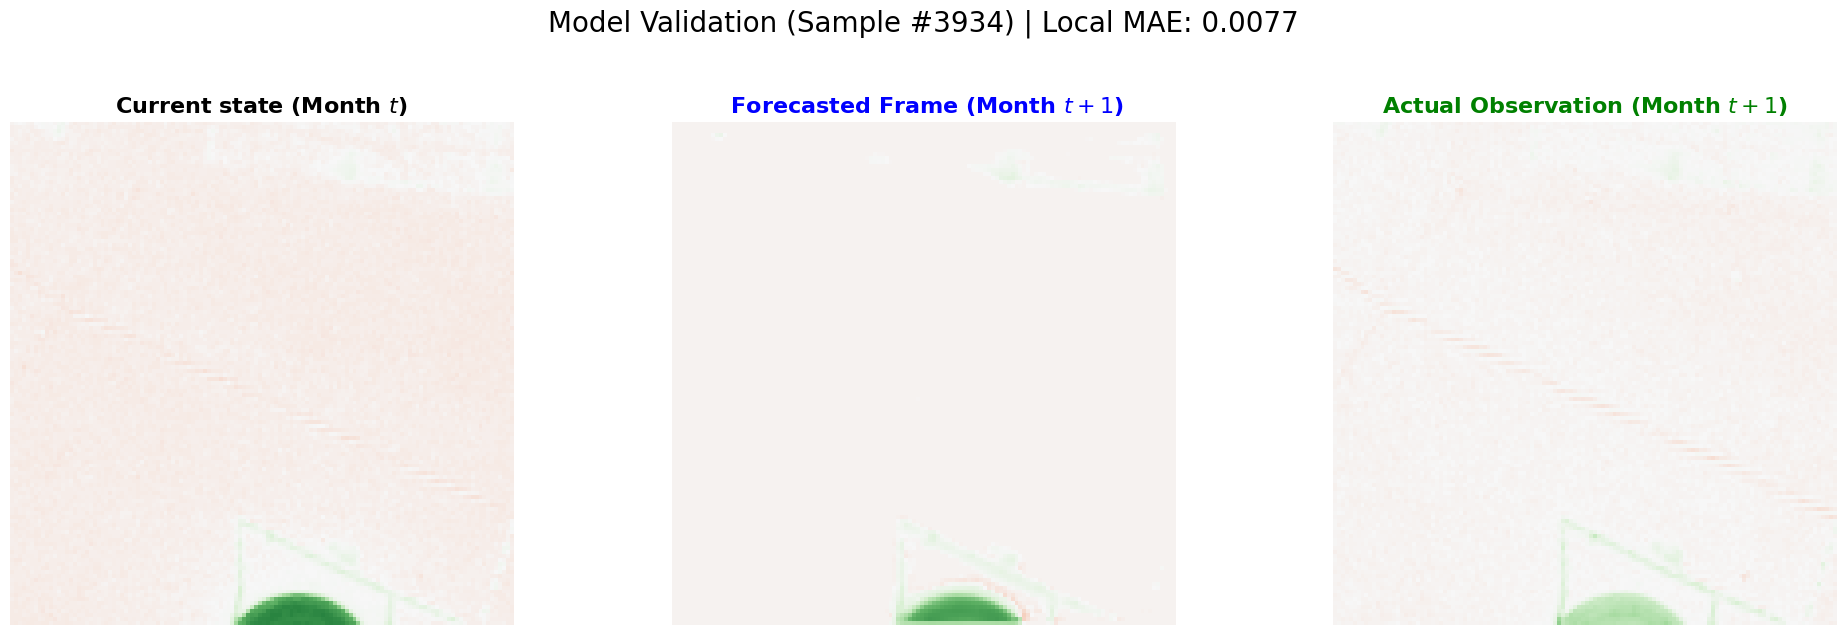

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import operator

veg_colors = ["#f4a582", "#f7f7f7", "#d9f0d3", "#a6dba0", "#5aae61", "#1b7837"]
cmap_veg = mcolors.LinearSegmentedColormap.from_list("Veg", veg_colors)

def find_best_prediction_solo():
    best_idx = -1
    best_error = 999999

    for i in range(50):
        idx = random.randint(0, len(X_test)-1)
        ground_truth = Y_test[idx:idx+1]

        has_vegetation = np.sum(ground_truth[0, :, :, 0] > 0.2) > 150

        if has_vegetation:
            sample_input = X_test[idx:idx+1]
            prediction = model.predict(sample_input, verbose=0)

            diff = np.abs(prediction[0, :, :, 0] - ground_truth[0, :, :, 0])
            total_error = np.sum(diff)

            if total_error < best_error:
                best_error = total_error
                best_idx = idx

    if best_idx == -1: best_idx = random.randint(0, len(X_test)-1)

    return best_idx

def plot_presentation_slide(index):
    sample_input = X_test[index:index+1]
    ground_truth = Y_test[index:index+1]
    prediction = model.predict(sample_input, verbose=0)

    sample_mae = np.mean(np.abs(prediction - ground_truth))

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. INPUT
    axes[0].imshow(sample_input[0, -1, :, :, 0], cmap=cmap_veg, vmin=-0.1, vmax=0.8, interpolation='nearest')
    axes[0].set_title(f"Current state (Month $t$)", fontsize=16, fontweight='bold')
    axes[0].axis('off')

    # 2. AI PREDICTION
    axes[1].imshow(prediction[0, :, :, 0], cmap=cmap_veg, vmin=-0.1, vmax=0.8, interpolation='nearest')
    axes[1].set_title(" Forecasted Frame (Month $t+1$)", fontsize=16, fontweight='bold', color='blue')
    axes[1].axis('off')

    # 3. REALITY
    axes[2].imshow(ground_truth[0, :, :, 0], cmap=cmap_veg, vmin=-0.1, vmax=0.8, interpolation='nearest')
    axes[2].set_title("Actual Observation (Month $t+1$)", fontsize=16, fontweight='bold', color='green')
    axes[2].axis('off')

    plt.suptitle(f"Model Validation (Sample #{index}) | Local MAE: {sample_mae:.4f}",
                 fontsize=20, y=1.05)
    plt.tight_layout()
    plt.show()


plot_presentation_slide(find_best_prediction_solo())

plot_presentation_slide(find_best_prediction_solo())

plot_presentation_slide(find_best_prediction_solo())
